In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.utils import shuffle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

def load_and_shuffle_data(train_address='./train.csv', test_address='./test.csv'):
    origin_train = pd.read_csv(train_address)
    origin_train = shuffle(origin_train)
    origin_test = pd.read_csv(test_address)
    return origin_train, origin_test

def nn_fitting(origin_train, N_HIDDEN=80, activate="tanh", optimizer=tf.keras.optimizers.Adamax(learning_rate=0.001)):
    y = origin_train['target']
    x = origin_train.drop(['target'], axis=1)
    x_norm = x  # You can standardize or normalize data here if needed
    X = np.array(x_norm)

    model = Sequential()
    model.add(Dense(N_HIDDEN, input_shape=(X.shape[1],), activation=activate))
    model.add(Dense(N_HIDDEN, activation=activate))
    model.add(Dense(N_HIDDEN, activation=activate))
    model.add(Dense(N_HIDDEN, activation=activate))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()

    opt = optimizer
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

    es_val_loss = EarlyStopping(monitor='val_loss', patience=2)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, mode='auto',
                                  min_delta=0.0001, cooldown=0, min_lr=1e-8)

    counts = np.bincount(y)
    weight_for_0 = 1.0 / counts[0]
    weight_for_1 = 1.0 / counts[1]
    class_weight = {0: weight_for_0, 1: weight_for_1}

    history = model.fit(X, y, callbacks=[reduce_lr, es_val_loss], epochs=100,
                        batch_size=128, validation_split=0.25, shuffle=True,
                        class_weight=class_weight, verbose=1)
    return model, history

def nn_fitting_visualization(history):
    history_dict = history.history

    # Plot training and validation loss
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    epochs = range(1, len(loss_values) + 1)

    plt.plot(epochs, loss_values, 'bo', label='Training loss')
    plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot training and validation accuracy
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']

    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'orange', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

def test_result(model, origin_test):
    test_y = origin_test['target']
    test_x = origin_test.drop(['target'], axis=1)
    # test_norm = test_x  # You can standardize or normalize data here if needed
    # test_x = np
    # prediction = np.round(model.predict(test_x), 0)
    y_pred = model.predict(test_x)
    prediction = np.round(y_pred).astype(int)
    confu_matrix = confusion_matrix(test_y, prediction)
    result_report = classification_report(test_y, prediction)
    AUC = roc_auc_score(test_y, prediction)

    print(confu_matrix)
    print(result_report)
    print(AUC)

    # ROC Curve for testing set
    score = model.predict(test_x)
    auc = roc_auc_score(test_y, score)
    fpr, tpr, _ = roc_curve(test_y, score)
    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plt.plot(fpr, tpr, color='darkorange',
            label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC for testing set')
    plt.legend(loc="lower right")

    # ROC Curve for training set
    train_x = origin_train.drop(['target'], axis=1)
    train_y = origin_train['target']
    score = model.predict(train_x)
    auc = roc_auc_score(train_y, score)
    fpr, tpr, _ = roc_curve(train_y, score)
    plt.subplot(122)
    plt.plot(fpr, tpr, color='darkorange',
            label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC for training set')
    plt.legend(loc="lower right")
    plt.show()
    return prediction




In [66]:
# prediction = np.round(model.predict(test_x), 0)
# confu_matrix = confusion_matrix(test_y, prediction)
# result_report = classification_report(test_y, prediction)
# AUC = roc_auc_score(test_y, prediction)

# print(confu_matrix)
# print(result_report)
# print(AUC)

# # ROC Curve for testing set
# score = model.predict(test_x)
# auc = roc_auc_score(test_y, score)
# fpr, tpr, _ = roc_curve(test_y, score)
# plt.figure(figsize=(12, 6))
# plt.subplot(121)
# plt.plot(fpr, tpr, color='darkorange',
#          label='ROC curve (area = %0.2f)' % auc)
# plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC for testing set')
# plt.legend(loc="lower right")

# # ROC Curve for training set
# train_x = origin_train.drop(['class'], axis=1)
# train_y = origin_train['class']
# score = model.predict(train_x)
# auc = roc_auc_score(train_y, score)
# fpr, tpr, _ = roc_curve(train_y, score)
# plt.subplot(122)
# plt.plot(fpr, tpr, color='darkorange',
#          label='ROC curve (area = %0.2f)' % auc)
# plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC for training set')
# plt.legend(loc="lower right")
# plt.show()
# return prediction


In [67]:
train_address = './train.csv'
test_address = './test.csv'

origin_train, origin_test = load_and_shuffle_data(train_address, test_address)


In [68]:
origin_train.shape

(4602, 95)

In [69]:
origin_train.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_85,feature_86,feature_87,feature_88,feature_89,feature_90,feature_91,feature_92,feature_93,target
4438,0.490031,0.502726,0.529632,0.593011,0.593011,0.998871,0.797264,0.809197,0.303510,0.781447,...,0.777833,0.005348,0.623770,0.593010,0.838623,0.279341,0.026692,0.564638,0.031006,0
1762,0.497489,0.572231,0.550083,0.606034,0.606034,0.999014,0.797555,0.809466,0.303720,0.781710,...,0.815613,0.023896,0.624040,0.606033,0.841298,0.277281,0.026931,0.565746,0.047464,0
3097,0.510993,0.573812,0.559131,0.619229,0.618984,0.999090,0.797517,0.809425,0.303495,0.781660,...,0.821773,0.004952,0.623933,0.619226,0.841485,0.276130,0.026820,0.565294,0.077038,0
3952,0.434456,0.489261,0.481717,0.628857,0.628173,0.998917,0.797266,0.809193,0.303417,0.781414,...,0.770904,0.000371,0.623789,0.628857,0.838635,0.276154,0.026791,0.565158,0.075941,0
1809,0.574904,0.621402,0.617164,0.625744,0.625744,0.999288,0.797775,0.809607,0.303531,0.781891,...,0.846280,0.001474,0.624114,0.625743,0.842769,0.275879,0.026791,0.565158,0.091038,0


In [70]:
trained_model, training_history = nn_fitting(origin_train)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 80)                7600      
                                                                 
 dense_31 (Dense)            (None, 80)                6480      
                                                                 
 dense_32 (Dense)            (None, 80)                6480      
                                                                 
 dense_33 (Dense)            (None, 80)                6480      
                                                                 
 dense_34 (Dense)            (None, 1)                 81        
                                                                 
Total params: 27,121
Trainable params: 27,121
Non-trainable params: 0


_________________________________________________________________
Epoch 1/100
27/27 [==============================] - 1s 9ms/step - loss: 3.1176e-04 - accuracy: 0.5233 - val_loss: 0.7682 - val_accuracy: 0.4283 - lr: 0.0010
Epoch 2/100
27/27 [==============================] - 0s 4ms/step - loss: 2.9361e-04 - accuracy: 0.5998 - val_loss: 0.7046 - val_accuracy: 0.5682 - lr: 0.0010
Epoch 3/100
27/27 [==============================] - 0s 4ms/step - loss: 2.8561e-04 - accuracy: 0.5146 - val_loss: 0.5774 - val_accuracy: 0.7150 - lr: 0.0010
Epoch 4/100
27/27 [==============================] - 0s 4ms/step - loss: 2.8231e-04 - accuracy: 0.6618 - val_loss: 0.6590 - val_accuracy: 0.6507 - lr: 0.0010
Epoch 5/100
23/27 [========================>.....] - ETA: 0s - loss: 2.6833e-04 - accuracy: 0.7208
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
27/27 [==============================] - 0s 4ms/step - loss: 2.7305e-04 - accuracy: 0.7036 - val_loss: 0.7140 - val_accuracy: 

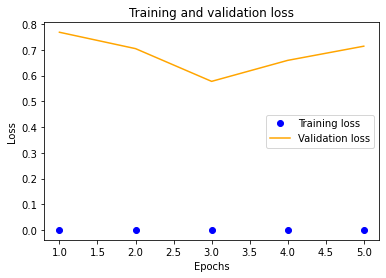

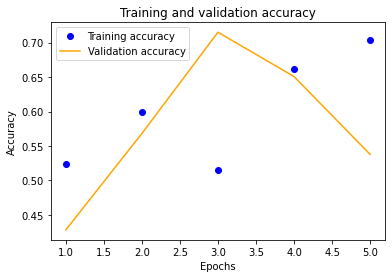

In [71]:
nn_fitting_visualization(training_history)

22/22 [==============================] - 0s 1ms/step
[[383 277]
 [ 12  10]]
              precision    recall  f1-score   support

           0       0.97      0.58      0.73       660
           1       0.03      0.45      0.06        22

    accuracy                           0.58       682
   macro avg       0.50      0.52      0.40       682
weighted avg       0.94      0.58      0.70       682

0.5174242424242425
144/144 [==============================] - 0s 1ms/step


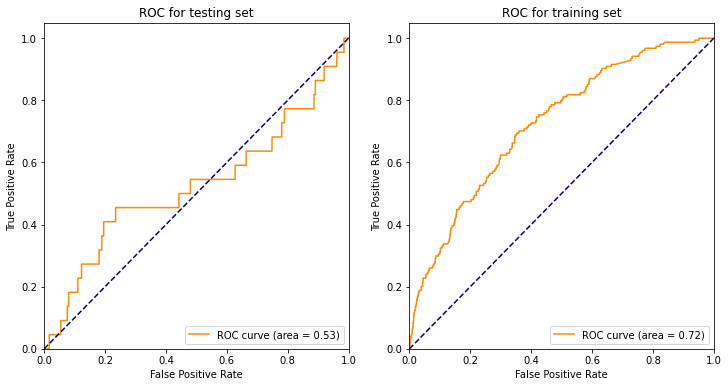

array([[1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
    

In [72]:


test_result(trained_model, origin_test)